# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import seaborn as sn
import plotnine as pln
import anndata
import scanpy as sc
import scvelo as scv
import sctk as sk
import cellrank as cr

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

In [2]:
sc.settings.verbosity = 0

In [2]:
import numpy_groupies as npg

In [3]:
import plotnine as pln
from plotnine import ggplot, aes

# Load data

In [2]:
ad = sc.read("../20200804_fig1/h5ad/fetal_skin.norm.20210401.h5ad")

Only considering the two last: ['.20210401', '.h5ad'].
Only considering the two last: ['.20210401', '.h5ad'].


In [5]:
ad

AnnData object with n_obs × n_vars = 187293 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_cells', 'cc', 'n_counts'
    obsm: 'X_umap1', 'X_umap2'

In [13]:
ad.obs_names[0:10]

Index(['AAACCTGGTCAGTGGA-1-4834STDY7002879',
       'AAAGATGGTCGATTGT-1-4834STDY7002879',
       'AAAGCAAAGATGTGGC-1-4834STDY7002879',
       'AAAGTAGCAGATCGGA-1-4834STDY7002879',
       'AAAGTAGTCCGCATCT-1-4834STDY7002879',
       'AAATGCCAGCTGCCCA-1-4834STDY7002879',
       'AAATGCCTCGTGGTCG-1-4834STDY7002879',
       'AACACGTAGAGAGCTC-1-4834STDY7002879',
       'AACCATGAGATCTGCT-1-4834STDY7002879',
       'AACCATGGTGCCTTGG-1-4834STDY7002879'],
      dtype='object', name='index')

In [67]:
tnk_ad = sc.read(
    "../20210423_TNK_reclustering/fetal_skin.lymphoid_T_NK.doublet_removed_processed.20210423.h5ad"
)

Only considering the two last: ['.20210423', '.h5ad'].
Only considering the two last: ['.20210423', '.h5ad'].


In [68]:
tnk_ad

AnnData object with n_obs × n_vars = 17943 × 20535
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'rachel_annot1', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5', 'leiden_hm_r0_4_split', 'rachel_annot2', 'leiden_hm_split1', 'rachel_annot3', 'leiden_hm_split2', 'leiden_hm_split3', 'leiden_hm_split4', 'nh3_annot1', '__is_in_cluster__'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'hvg_full'
    uns: "dendrogram_['nh3_annot1']", 'leiden', 'neighbors', 'neighbo

In [69]:
tnk_ad.obs.nh3_annot1.cat.categories

Index(['CD4 T cell', 'CD8 T cell', 'Treg', 'NK cell', 'NK cell 2', 'NKT cell?',
       'gdT cell?', 'Unknown T cell', 'LTi cell', 'ILC2', 'ILC3',
       'Lymphoid progenitor'],
      dtype='object')

In [72]:
tnk_ad.obs.nh3_annot1.cat.rename_categories(
    {"NKT cell?": "NKT cell", "gdT cell?": "gdT cell"}, inplace=True
)

In [14]:
maternal_cells = pd.read_csv(
    "../20200804_fig1/pan_fetal_souporcell/maternal_barcodes.csv", index_col=0
).x

In [15]:
maternal_cells[0:10]

1     FCAImmP7241242-TTCTTAGTCAGCGATT
2     FCAImmP7241242-TACACGAAGCCCAACC
3     FCAImmP7241242-GTCGTAAGTGGGTCAA
4     FCAImmP7241242-TAGAGCTTCCGATATG
5     FCAImmP7241242-TGATTTCTCAGCAACT
6     FCAImmP7241242-GTCTCGTCACTTAAGC
7     FCAImmP7241242-ACTTGTTCAATCCAAC
8     FCAImmP7241242-AAGACCTGTGATGCCC
9     FCAImmP7241242-AGGTCCGAGGCATGTG
10    FCAImmP7241242-TCACGAACATCACGTA
Name: x, dtype: object

In [28]:
m_cell_df = maternal_cells.str.partition("-")[[0, 2]]

In [30]:
m_cell_df.columns = ["sanger_id", "barcode"]

In [32]:
m_cell_df.loc[~m_cell_df.barcode.str.endswith("-1"), "barcode"] = (
    m_cell_df.loc[~m_cell_df.barcode.str.endswith("-1"), "barcode"].astype(str) + "-1"
)

In [35]:
m_cells = (m_cell_df.barcode.astype(str) + "-" + m_cell_df.sanger_id.astype(str)).to_list()

In [38]:
len(m_cells)

3715

# Update T/NK/ILC annotation

In [78]:
np.all(ad.obs_names[ad.obs_names.isin(tnk_ad.obs_names)] == tnk_ad.obs_names)

True

In [81]:
np.all(tnk_ad.obs_names.isin(ad.obs_names))

True

In [ ]:
ad.obs["independent_annotation_refined"] = ad.obs["independent_annotation_refined"].astype(str)
ad.obs.loc[
    ad.obs_names.isin(tnk_ad.obs_names), "independent_annotation_refined"
] = tnk_ad.obs.nh3_annot1.values
ad.obs["independent_annotation_refined"] = ad.obs["independent_annotation_refined"].astype(
    "category"
)

# Add figure1b annotation

In [89]:
ad.obs["fig1b_annotation"] = sk.regroup(
    ad,
    groupby="independent_annotation_broad1",
    regroups={
        "Fibroblast": [
            "Fibroblast WNT2+",
            "Fibroblast HF",
            "Fibroblast HOX5+",
            "Fibroblast unknown",
            "Fibroblast FRZB+",
        ],
        "Dermal condensate": [
            "Fibroblast dermal papillia",
        ],
        "Keratinocyte": [
            "Basal KC",
            "Suprabasal KC",
            "HF KC",
            "Periderm",
        ],
        "Monocyte": [
            "Monocyte precursor",
        ],
        "ILC": [
            "NK cell",
            "Lymphoid progenitor",
            "ILC2",
            "ILC3",
            "Lti",
        ],
        "T cell": [
            "Treg",
            "CD4 T cell",
            "CD8 T cell",
            "NK T cell",
        ],
        "Macrophage": [
            "Mac-mono",
        ],
        "Melanocyte": [
            "Melanoblast",
        ],
        "Erythroid": [
            "Early erythroid",
        ],
        "cDC": [
            "DC1",
            "DC2",
            "ASDC",
        ],
        "Progenitor": [
            "Granulocyte progenitor",
            "HSC",
            "MEMP",
        ],
    },
)

In [90]:
ad.obs["fig1b_annotation"] = ad.obs["fig1b_annotation"].astype(str)
ad.obs.loc[ad.obs.independent_annotation_refined == "Unknown T cell", "fig1b_annotation"] = "T cell"
ad.obs["fig1b_annotation"] = ad.obs["fig1b_annotation"].astype("category")

In [91]:
ad.obs.fig1b_annotation.cat.categories

Index(['Adipocyte', 'B cell', 'Dermal condensate', 'Erythroid', 'Fibroblast',
       'ILC', 'Keratinocyte', 'Langerhans cell', 'Lymphatic endothelium',
       'Macrophage', 'Mast cell', 'Megakaryocyte', 'Melanocyte', 'Microglia',
       'Monocyte', 'Myofibroblast', 'Neuronal cells', 'Neutrophil', 'Pericyte',
       'Progenitor', 'Schwann cell', 'Skeletal muscle', 'Smooth muscle',
       'T cell', 'Vascular endothelium', 'cDC', 'pDC'],
      dtype='object')

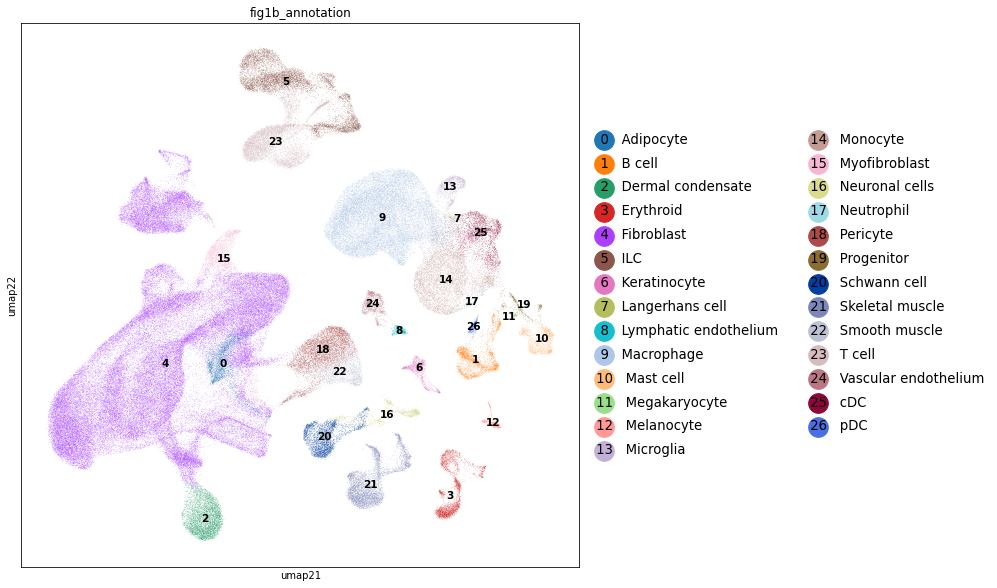

In [95]:
sk.plot_embedding(
    ad, basis="umap2", groupby="fig1b_annotation", figsize=(10, 10), legend_fontsize=12
);

# Clean up maternal cells

In [84]:
ad.obs["is_maternal"] = ad.obs_names.isin(m_cells)

In [85]:
maternal_prop_df = pd.DataFrame(
    {
        "celltype": ad.obs.independent_annotation_refined.cat.categories,
        "maternal_prop": npg.aggregate(
            ad.obs.independent_annotation_refined.cat.codes, ad.obs.is_maternal.astype(int), "mean"
        ),
    }
)

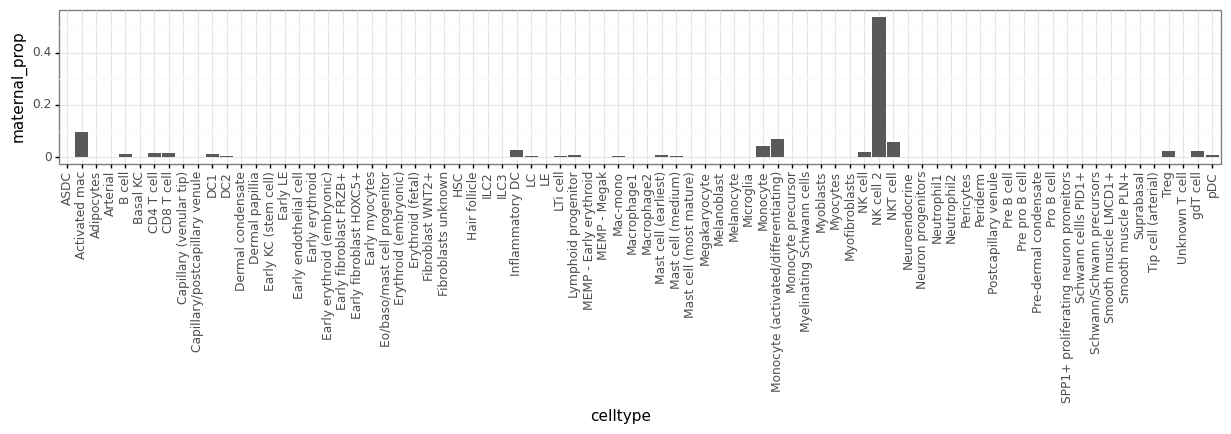

<ggplot: (8771972086577)>


In [86]:
pln.options.figure_size = (15, 2)
print(
    ggplot(maternal_prop_df, aes(x="celltype", y="maternal_prop"))
    + pln.geom_bar(stat="identity")
    + pln.theme_bw()
    + pln.theme(axis_text_x=pln.element_text(rotation=90))
);

In [96]:
ad1 = ad[~ad.obs.is_maternal].copy()

# Update pericyte/smooth muscle and T annotation (20211208)

In [77]:
ad1 = sc.read("fetal_skin.norm.maternal_removed.20210611.h5ad", backed="r")

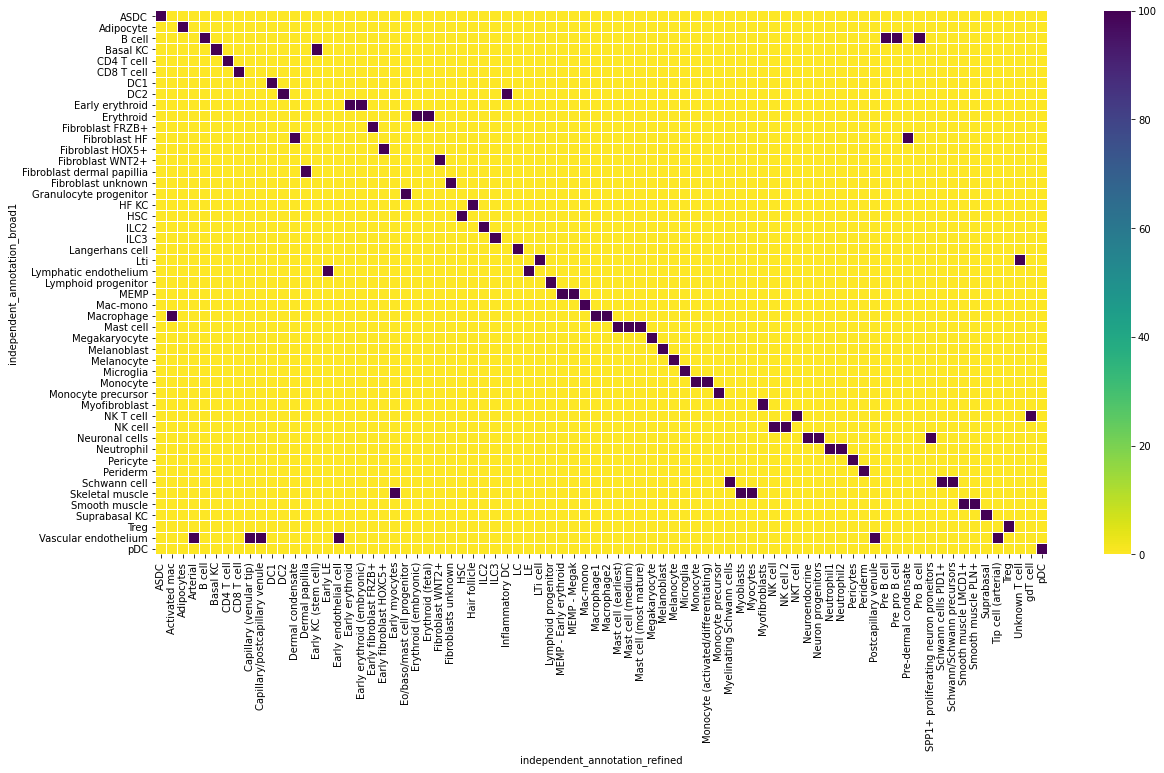

In [78]:
sk.cross_table(
    ad1,
    "independent_annotation_broad1",
    "independent_annotation_refined",
    normalise="y",
    plot=True,
    figsize=(20, 10),
);

In [79]:
ad1.obs["independent_annotation_refined"] = ad1.obs["independent_annotation_refined"].astype(str)
ad1.obs.loc[
    ad1.obs.independent_annotation_refined.isin(["gdT cell", "NKT cell"]),
    "independent_annotation_refined",
] = "Innate T type1"
ad1.obs.loc[
    ad1.obs.independent_annotation_refined == "Unknown T cell", "independent_annotation_refined"
] = "Innate T type3"
ad1.obs.loc[
    ad1.obs.independent_annotation_refined == "Smooth muscle PLN+", "independent_annotation_refined"
] = "Contractile pericyte"
ad1.obs.loc[
    ad1.obs.independent_annotation_refined == "Smooth muscle LMCD1+",
    "independent_annotation_refined",
] = "Angiogenic pericyte"
ad1.obs.loc[
    ad1.obs.independent_annotation_refined == "Fibroblasts unknown",
    "independent_annotation_refined",
] = "Fibroblast PEAR1+"
ad1.obs["independent_annotation_refined"] = ad1.obs["independent_annotation_refined"].astype(
    "category"
)

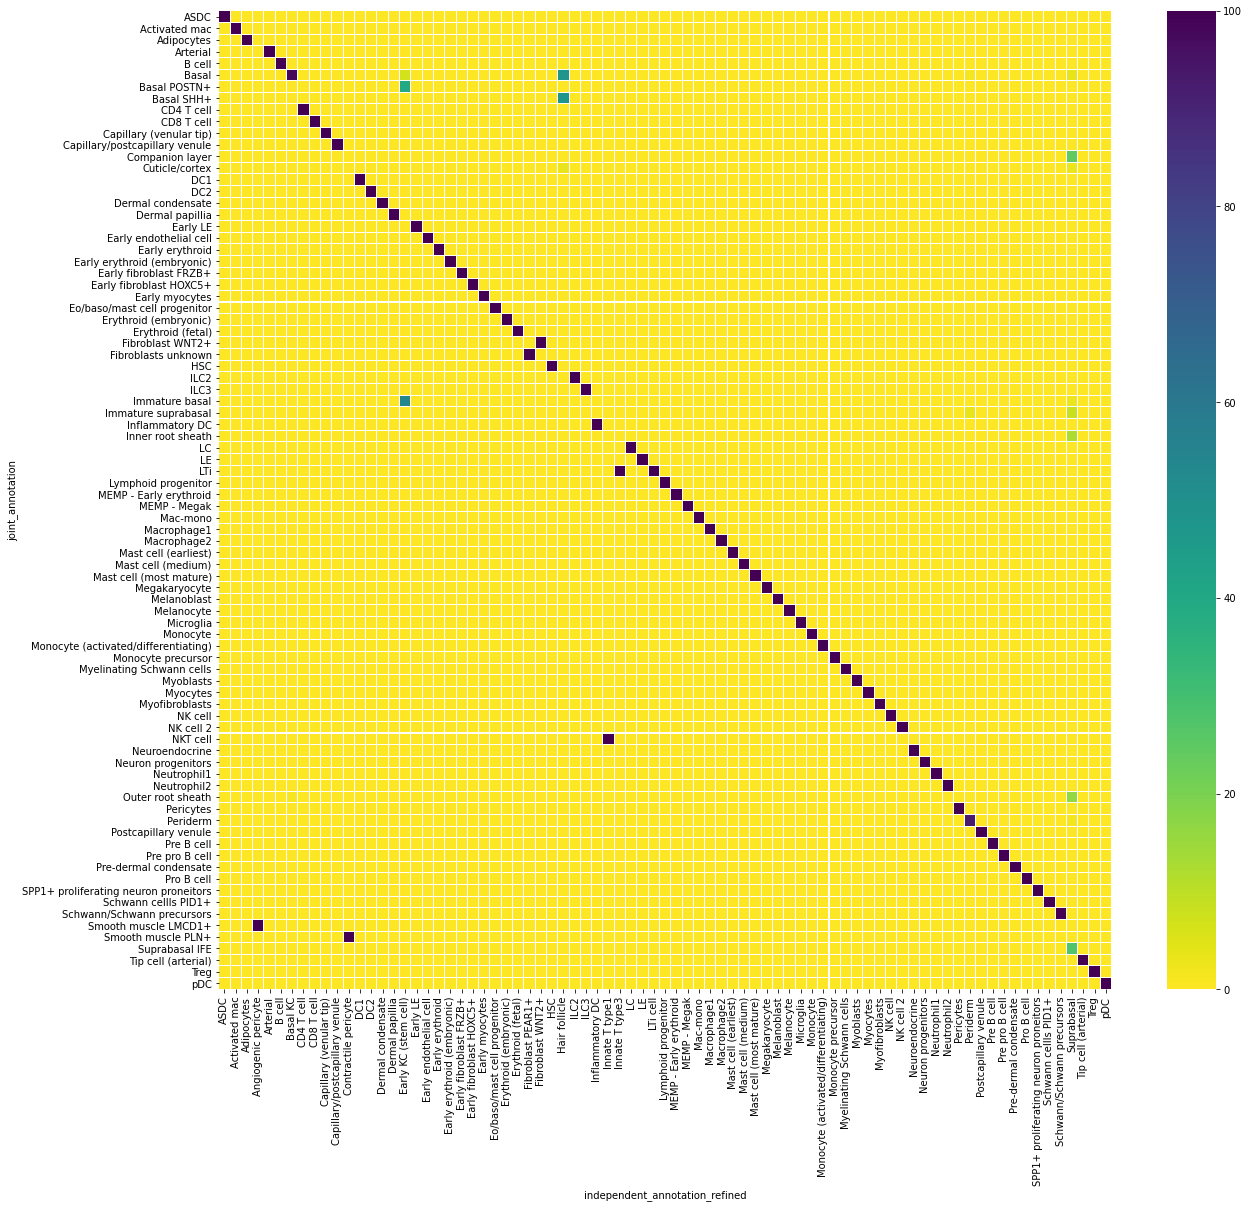

In [80]:
sk.cross_table(
    ad1,
    "joint_annotation",
    "independent_annotation_refined",
    normalise="y",
    plot=True,
    figsize=(20, 18),
);

In [81]:
ad1.obs["joint_annotation"] = ad1.obs["joint_annotation"].astype(str)
ad1.obs.loc[
    ad1.obs.independent_annotation_refined == "Innate T type1", "joint_annotation"
] = "Innate T type1"
ad1.obs.loc[
    ad1.obs.independent_annotation_refined == "Innate T type3", "joint_annotation"
] = "Innate T type3"
ad1.obs.loc[
    ad1.obs.joint_annotation == "Smooth muscle PLN+", "joint_annotation"
] = "Contractile pericyte"
ad1.obs.loc[
    ad1.obs.joint_annotation == "Smooth muscle LMCD1+", "joint_annotation"
] = "Angiogenic pericyte"
ad1.obs.loc[
    ad1.obs.joint_annotation == "Fibroblasts unknown", "joint_annotation"
] = "Fibroblast PEAR1+"
ad1.obs["joint_annotation"] = ad1.obs["joint_annotation"].astype("category")

# Update broad annotations

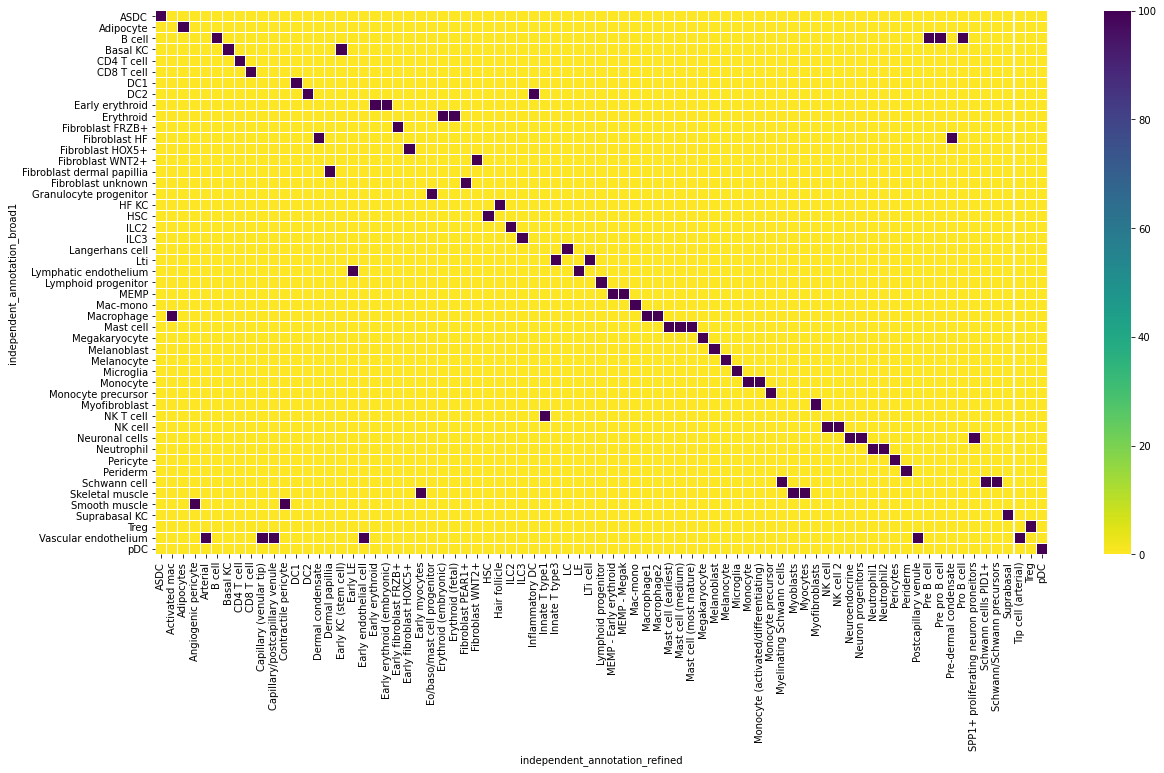

In [82]:
sk.cross_table(
    ad1,
    "independent_annotation_broad1",
    "independent_annotation_refined",
    normalise="y",
    plot=True,
    figsize=(20, 10),
);

In [83]:
ad1.obs["independent_annotation_broad1"] = ad1.obs["independent_annotation_broad1"].astype(str)
ad1.obs.loc[
    ad1.obs.independent_annotation_refined.isin(["Innate T type1", "Innate T type3"]),
    "independent_annotation_broad1",
] = "Innate T cell"
ad1.obs.loc[
    ad1.obs.independent_annotation_broad1 == "Smooth muscle", "independent_annotation_broad1"
] = "Pericyte"
ad1.obs["independent_annotation_broad1"] = ad1.obs["independent_annotation_broad1"].astype(
    "category"
)

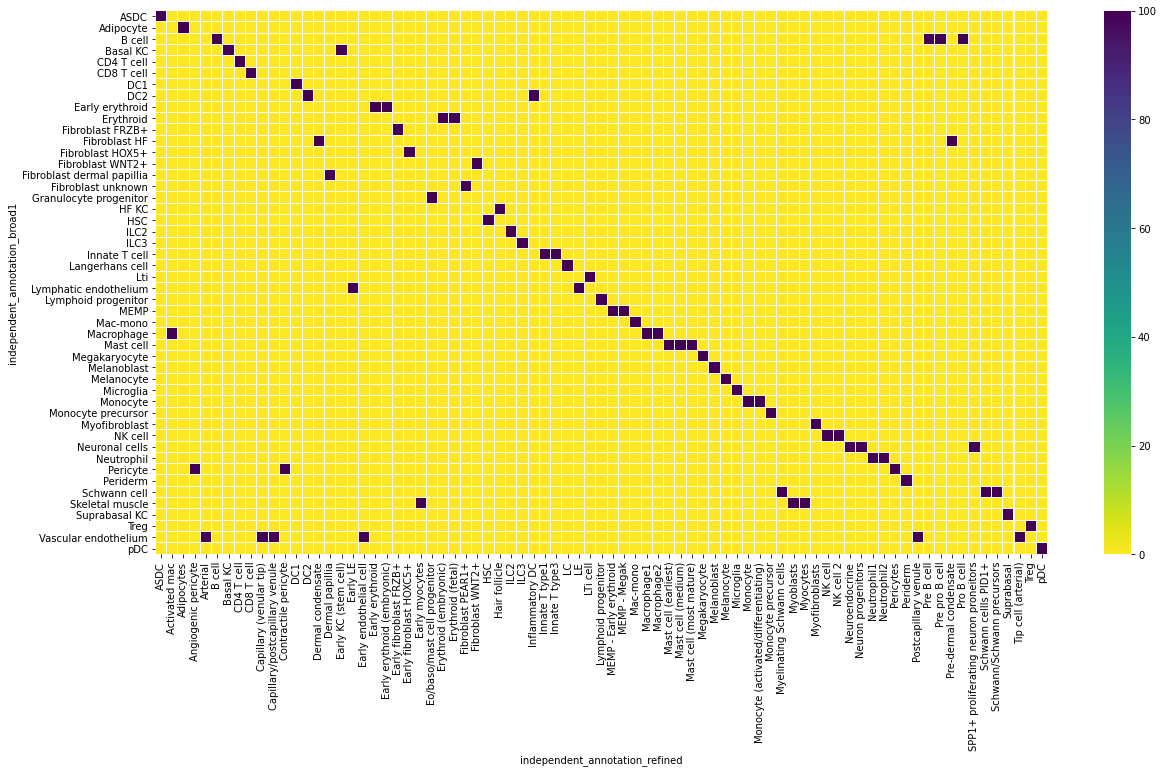

In [84]:
sk.cross_table(
    ad1,
    "independent_annotation_broad1",
    "independent_annotation_refined",
    normalise="y",
    plot=True,
    figsize=(20, 10),
);

In [85]:
ad1.obs["independent_annotation_broad1"] = ad1.obs["independent_annotation_broad1"].astype(str)
ad1.obs.loc[
    ad1.obs.independent_annotation_refined.isin(["Innate T type1", "Innate T type3"]),
    "independent_annotation_broad1",
] = "Innate T cell"
ad1.obs["independent_annotation_broad1"] = ad1.obs["independent_annotation_broad1"].astype(
    "category"
)

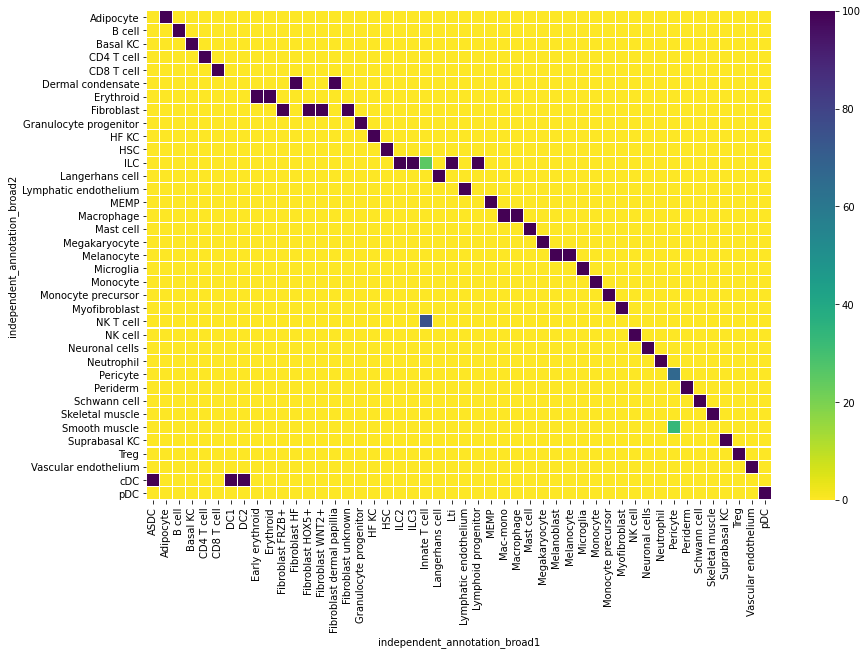

In [86]:
sk.cross_table(
    ad1,
    "independent_annotation_broad2",
    "independent_annotation_broad1",
    normalise="y",
    plot=True,
    figsize=(14, 9),
);

In [87]:
ad1.obs["independent_annotation_broad2"] = ad1.obs["independent_annotation_broad2"].astype(str)
ad1.obs.loc[
    ad1.obs.independent_annotation_broad1 == "Innate T cell", "independent_annotation_broad2"
] = "Innate T cell"
ad1.obs.loc[
    ad1.obs.independent_annotation_broad2 == "Smooth muscle", "independent_annotation_broad2"
] = "Pericyte"
ad1.obs["independent_annotation_broad2"] = ad1.obs["independent_annotation_broad2"].astype(
    "category"
)

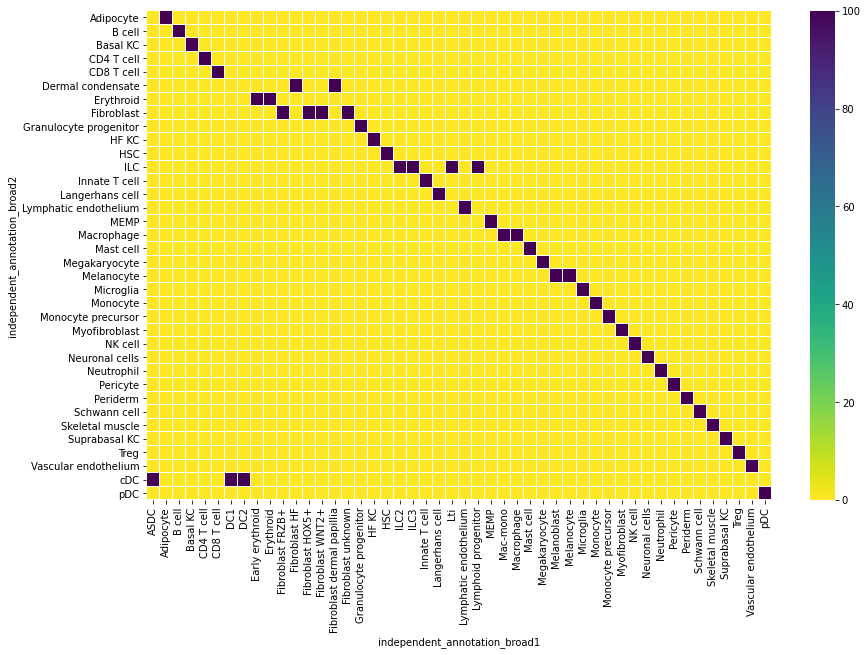

In [88]:
sk.cross_table(
    ad1,
    "independent_annotation_broad2",
    "independent_annotation_broad1",
    normalise="y",
    plot=True,
    figsize=(14, 9),
);

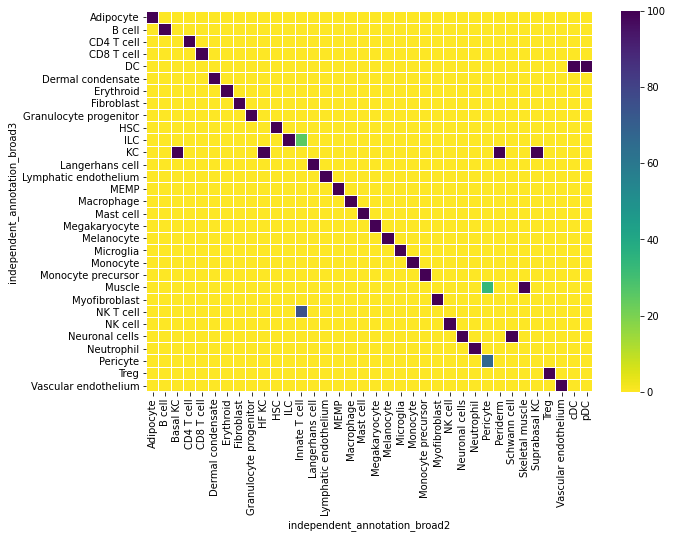

In [89]:
sk.cross_table(
    ad1,
    "independent_annotation_broad3",
    "independent_annotation_broad2",
    normalise="y",
    plot=True,
    figsize=(10, 7),
);

In [90]:
ad1.obs["independent_annotation_broad3"] = ad1.obs["independent_annotation_broad3"].astype(str)
ad1.obs.loc[
    ad1.obs.independent_annotation_broad2.isin(
        ["CD4 T cell", "CD8 T cell", "Treg", "Innate T cell"]
    ),
    "independent_annotation_broad3",
] = "T cell"
ad1.obs.loc[
    ad1.obs.independent_annotation_broad2 == "Pericyte", "independent_annotation_broad3"
] = "Pericyte"
ad1.obs["independent_annotation_broad3"] = ad1.obs["independent_annotation_broad3"].astype(
    "category"
)

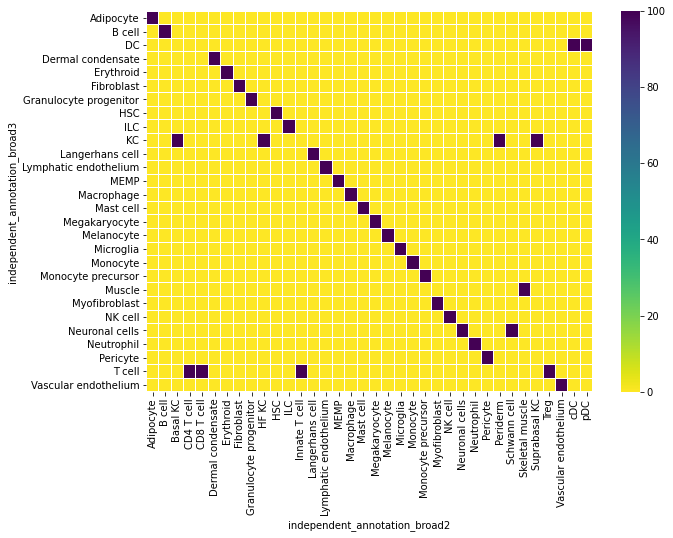

In [91]:
sk.cross_table(
    ad1,
    "independent_annotation_broad3",
    "independent_annotation_broad2",
    normalise="y",
    plot=True,
    figsize=(10, 7),
);

In [92]:
ad1.obs["independent_annotation_broad4"] = ad1.obs["independent_annotation_broad4"].astype(str)
ad1.obs.loc[
    ad1.obs.independent_annotation_broad3.isin(["Langerhans cell"]), "independent_annotation_broad4"
] = "Antigen Presenting Cells"
ad1.obs["independent_annotation_broad4"] = ad1.obs["independent_annotation_broad4"].astype(
    "category"
)

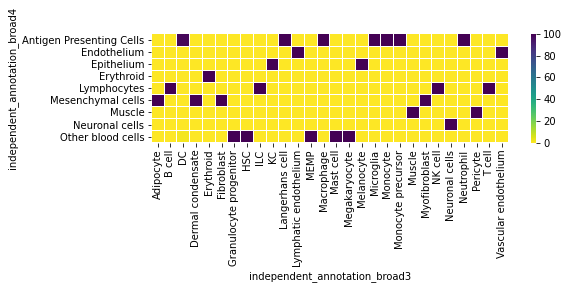

In [93]:
sk.cross_table(
    ad1,
    "independent_annotation_broad4",
    "independent_annotation_broad3",
    normalise="y",
    plot=True,
    figsize=(8, 2),
);

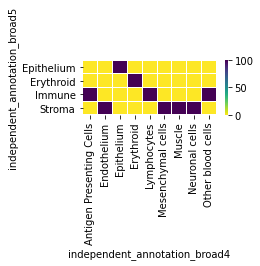

In [94]:
sk.cross_table(
    ad1,
    "independent_annotation_broad5",
    "independent_annotation_broad4",
    normalise="y",
    plot=True,
    figsize=(3, 1),
);

In [95]:
ad1.obs["fig1b_annotation"] = sk.regroup(
    ad1, groupby="fig1b_annotation", regroups={"Pericyte": ["Pericyte", "Smooth muscle"]}
)

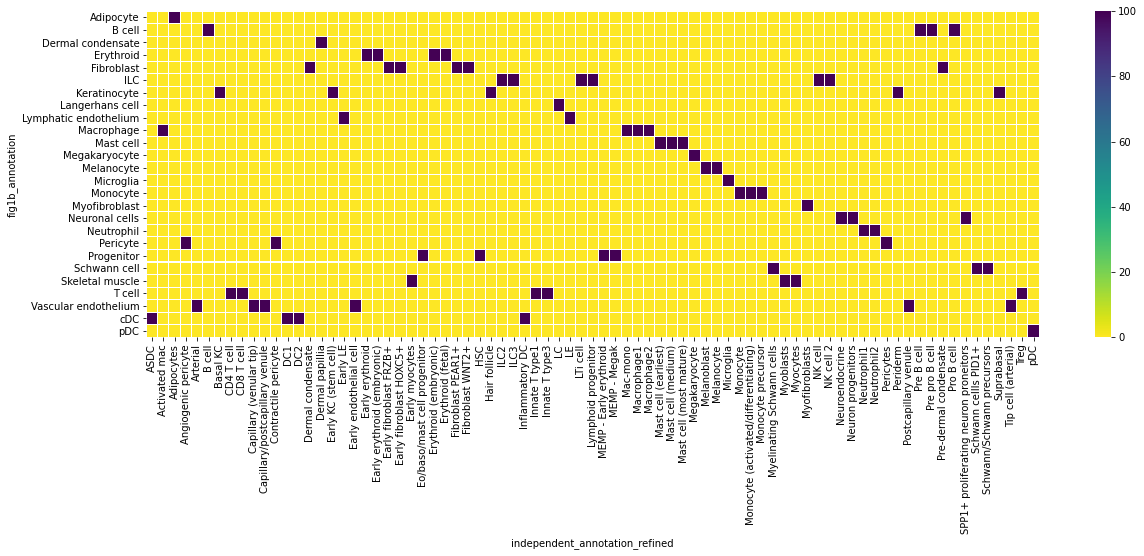

In [96]:
sk.cross_table(
    ad1,
    "fig1b_annotation",
    "independent_annotation_refined",
    normalise="y",
    plot=True,
    figsize=(20, 6),
);

In [97]:
new_obs = ad1.obs.copy()

In [98]:
del ad1

# Save object

In [99]:
ad1 = sc.read("fetal_skin.norm.maternal_removed.20210611.h5ad")

In [100]:
ad1.obs = new_obs

In [101]:
sk.clear_colors(ad1)
ad1.write("fetal_skin.norm.maternal_removed.20211215.h5ad", compression="lzf")

In [7]:
ad1 = sc.read("fetal_skin.norm.maternal_removed.20211215.h5ad")

In [102]:
pd.crosstab(ad1.obs.independent_annotation_refined, [ad1.obs.donor, ad1.obs.sorting]).T.to_csv(
    "cell_counts_by_donor_sorting_celltype.20211215.csv"
)

In [103]:
pd.crosstab(ad1.obs.independent_annotation_refined, ad1.obs.sanger_id).T.to_csv(
    "cell_counts_by_sample_celltype.20211215.csv"
)

In [104]:
ad1.obs.to_csv("fetal_skin.norm.maternal_removed.20211215.obs.csv.gz")

In [105]:
ad1S = sk.subsample(ad1, fraction=1, groupby="independent_annotation_refined", min_n=200, max_n=200)

In [106]:
ad1S

AnnData object with n_obs × n_vars = 14018 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_cells', 'cc', 'n_counts'
    obsm: 'X_umap1', 'X_umap2'

In [107]:
ad1S.write("fetal_skin.norm.maternal_removed.downsampled_rnd200.20211215.h5ad", compression="lzf")

In [108]:
ad1S = sc.read("fetal_skin.norm.maternal_removed.downsampled_rnd200.20211208.h5ad")

In [109]:
ad1S.obs[["independent_annotation_refined"]].to_csv(
    "fetal_skin.norm.maternal_removed.downsampled_rnd200.20211215.obs.tsv", sep="\t"
)

In [8]:
ad1Sj = sk.subsample(ad1, fraction=1, groupby="joint_annotation", min_n=100, max_n=100)

In [9]:
ad1Sj.write("fetal_skin.norm.maternal_removed.downsampled_by_joint_annotation_rnd100.20211215.h5ad", compression="lzf")

In [10]:
sk.LR_train(ad1Sj, groupby="joint_annotation", use_rep="X", save="fetal_skin.norm.maternal_removed.downsampled_by_joint_annotation_rnd100.lognorm.pkl")

LogisticRegression(C=0.1, n_jobs=-1, solver='saga', warm_start=True)

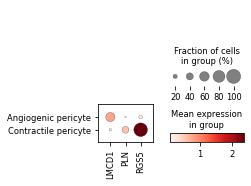

In [5]:
sc.pl.dotplot(ad1[ad1.obs.joint_annotation.str.contains('pericyte')], ['LMCD1', 'PLN', 'RGS5'], groupby='joint_annotation')

# Make cellxgene objects per compartment

In [110]:
old_cxg_path = "/mnt/farm/data/cellxgene/rachel_fetal_skin"

In [111]:
old_h5ads = {
    "endothelium": f"{old_cxg_path}/20200403/fetal_skin.endothelium.doublet_removed_processed.20200403.h5ad",
    "lymphoid_T_NK": f"{old_cxg_path}/20200403/fetal_skin.lymphoid_T_NK.doublet_removed_processed.20200403.h5ad",
    "erythroid": f"{old_cxg_path}/20200403/fetal_skin.erythroid.doublet_removed_processed.20200403.h5ad",
    "mast": f"{old_cxg_path}/20200403/fetal_skin.mast_cells.doublet_removed_processed.20200403.h5ad",
    "keratinocytes": f"{old_cxg_path}/20200403/fetal_skin.keratinocytes.doublet_removed_processed.20200403.h5ad",
    "melanocytes": f"{old_cxg_path}/20200403/fetal_skin.melanocytes.doublet_removed_processed.20200403.h5ad",
    "lymphoid_B": f"{old_cxg_path}/20200403/fetal_skin.lymphoid_B.doublet_removed_processed.20200403.h5ad",
    "myeloid": f"{old_cxg_path}/20200403/fetal_skin.myeloid.doublet_removed_processed.20200403.h5ad",
    "muscle": f"{old_cxg_path}/20200626/fetal_skin.muscle_cells_pass2.processed.cellxgene.h5ad",
    "neuronal": f"{old_cxg_path}/20200626/fetal_skin.neuronal_cells_pass2.processed.cellxgene.h5ad",
    "fibroblasts": f"{old_cxg_path}/20200529/fetal_skin.fibroblast.doublet_removed_processed_redo.20200605.h5ad",
    "stroma": f"{old_cxg_path}/20200626/fetal_skin.stroma_cells_pass2.processed.annotated.cellxgene.h5ad",
}

In [112]:
for name, h5ad in old_h5ads.items():
    print(name, end=": ")
    old_ad = sc.read(h5ad, backed="r")
    old_k = old_ad.obs_names.isin(ad1.obs_names)
    common_cells = old_ad.obs_names[old_k]
    print(common_cells.size)
    if common_cells.size == 0 or np.any(
        common_cells != ad1.obs_names[ad1.obs_names.isin(common_cells)]
    ):
        print(f"pass {name}")
        continue
    new_ad = ad1[ad1.obs_names.isin(common_cells)]
    for obsm_key in old_ad.obsm.keys():
        embed = old_ad.obsm[obsm_key][old_k, :]
        new_ad.obsm[obsm_key] = embed.copy()
    new_ad.write(f"cellxgene_h5ad/fetal_skin.{name}.cellxgene.20211215.h5ad", compression="lzf")
    del new_ad

endothelium: 2173
lymphoid_T_NK: 17600
erythroid: 3468
mast: 2641
keratinocytes: 1469
melanocytes: 794
lymphoid_B: 3676
myeloid: 35151
muscle: 15188
neuronal: 5643
fibroblasts: 90807
stroma: 119610


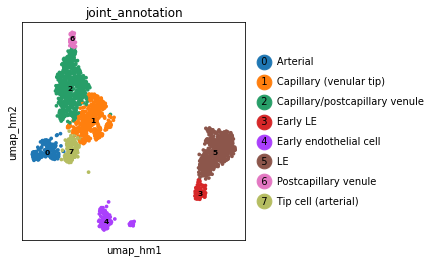

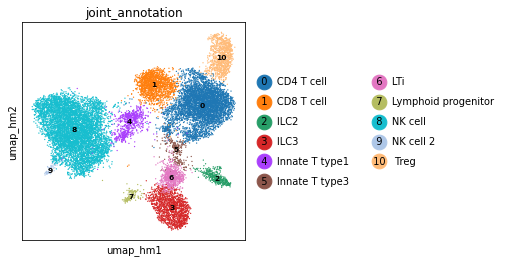

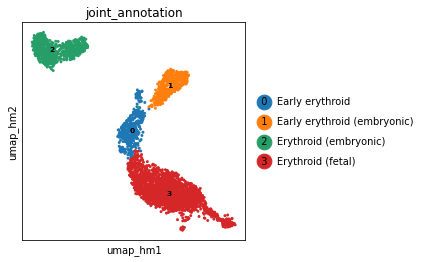

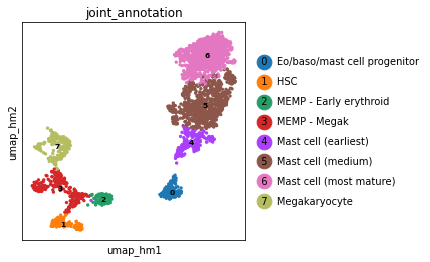

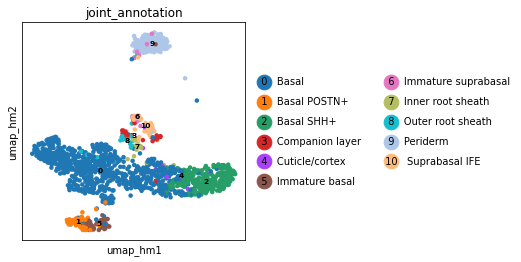

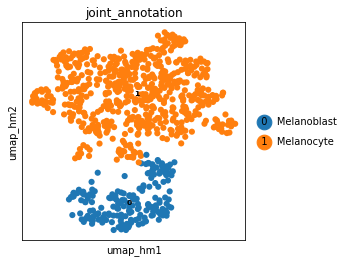

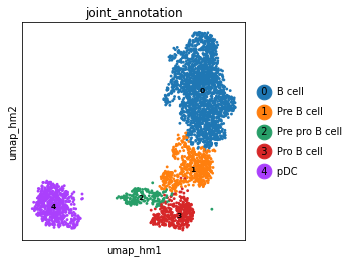

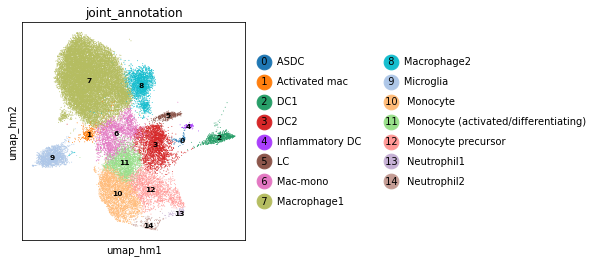

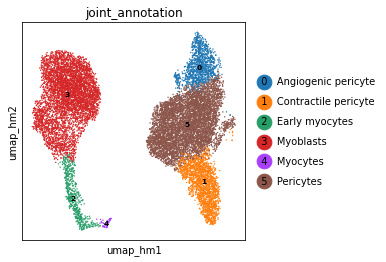

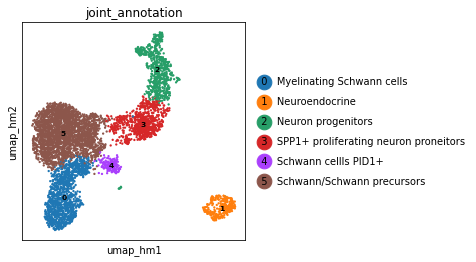

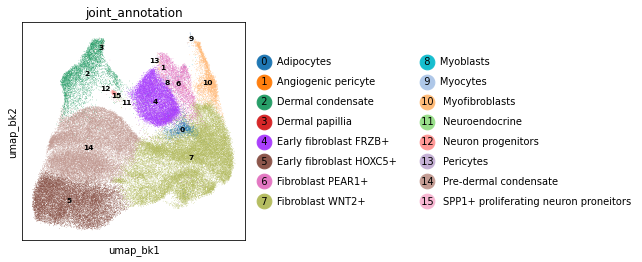

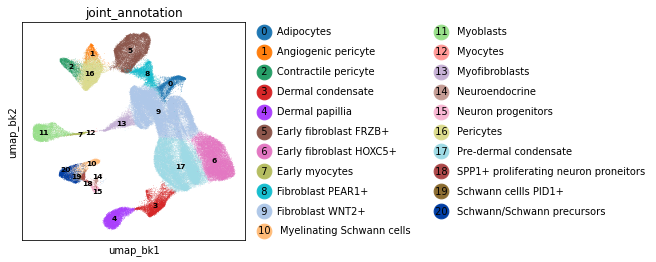

In [113]:
for name in old_h5ads.keys():
    new_ad = sc.read(f"cellxgene_h5ad/fetal_skin.{name}.cellxgene.20211215.h5ad", backed="r")
    basis = "umap_bk" if name in ("stroma", "fibroblasts") else "umap_hm"
    sk.plot_embedding(new_ad, basis=basis, groupby="joint_annotation");
    sk.clear_colors(new_ad)
    del new_ad

# Generate DE genes

In [4]:
ad1 = sc.read("fetal_skin.norm.maternal_removed.20210611.h5ad")

Only considering the two last: ['.20210611', '.h5ad'].
Only considering the two last: ['.20210611', '.h5ad'].


In [5]:
ad1

AnnData object with n_obs × n_vars = 186582 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_cells', 'cc', 'n_counts'
    obsm: 'X_umap1', 'X_umap2'

In [50]:
mkst = sk.calc_marker_stats(ad1S, groupby="independent_annotation_refined")

In [51]:
mks = sk.filter_marker_stats(mkst[2], max_next_frac=0.3, min_mean_diff=0.2)

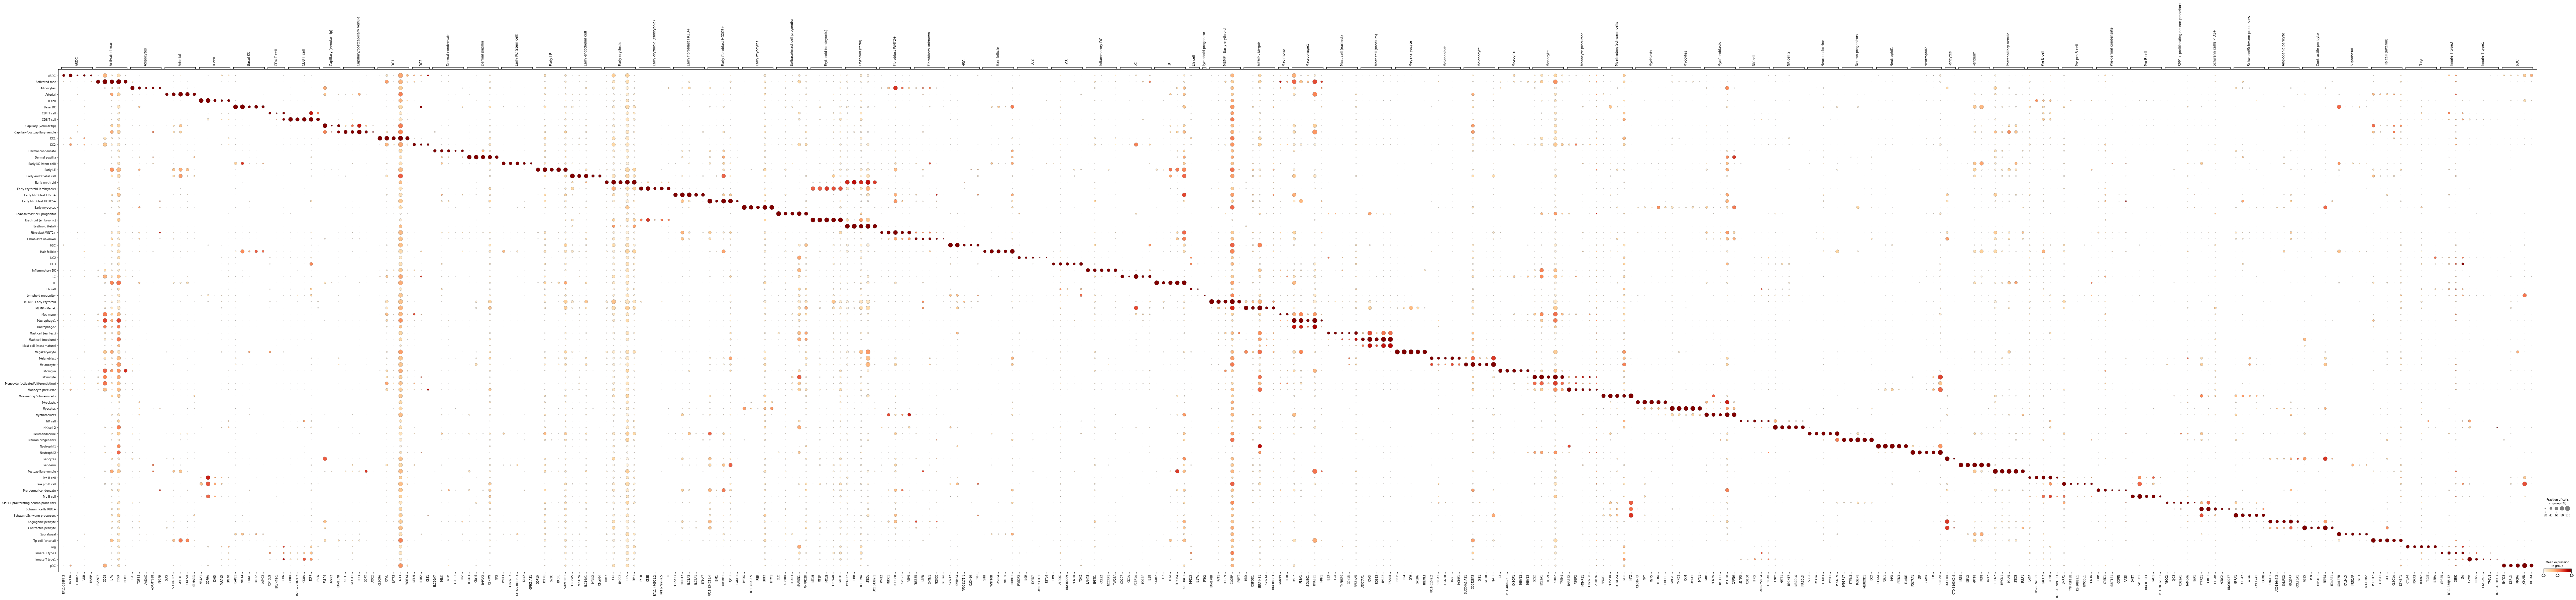

In [52]:
sk.plot_markers(
    ad1, groupby="independent_annotation_refined", mks=mks, standard_scale="var", cmap="OrRd"
)

In [16]:
ad1.obs.independent_annotation_broad5.cat.categories

Index(['Epithelium', 'Erythroid', 'Immune', 'Stroma'], dtype='object')

In [15]:
ad1.obs.independent_annotation_broad4.cat.categories

Index(['Antigen Presenting Cells', 'Endothelium', 'Epithelium', 'Erythroid',
       'Lymphocytes', 'Mesenchymal cells', 'Muscle', 'Neuronal cells',
       'Other blood cells'],
      dtype='object')

In [17]:
ad1.obs.independent_annotation_broad3.cat.categories

Index(['Adipocyte', 'B cell', 'CD4 T cell', 'CD8 T cell', 'DC',
       'Dermal condensate', 'Erythroid', 'Fibroblast',
       'Granulocyte progenitor', 'HSC', 'ILC', 'KC', 'Langerhans cell',
       'Lymphatic endothelium', 'MEMP', 'Macrophage', 'Mast cell',
       'Megakaryocyte', 'Melanocyte', 'Microglia', 'Monocyte',
       'Monocyte precursor', 'Muscle', 'Myofibroblast', 'NK T cell', 'NK cell',
       'Neuronal cells', 'Neutrophil', 'Pericyte', 'Treg',
       'Vascular endothelium'],
      dtype='object')

In [18]:
ad1Ss = sk.split_by_group(ad1S, groupby="independent_annotation_broad4")

In [19]:
deg_dict = {}

In [22]:
for ct, tmp_ad in ad1Ss.items():
    tmp_mkst = sk.calc_marker_stats(ad1Ss[ct], groupby="independent_annotation_refined")
    tmp_mks = sk.filter_marker_stats(tmp_mkst[2], max_next_frac=0.3, min_mean_diff=0.2)
    deg_dict[ct] = sk.test_markers(
        ad1Ss[ct], tmp_mks, groupby="independent_annotation_refined", method="wilcoxon"
    )

In [23]:
gc.collect()

6283

In [24]:
deg_dict["Endothelium"]

genes              cluster  top_frac  frac_diff  max_frac_diff  \
0          CXCL12             Arterial  0.796512   0.496512       0.565168   
1           EGFL8             Arterial  0.784884   0.330983       0.471451   
2            GJA5             Arterial  0.540698   0.510847       0.530698   
3           GRIA2             Arterial  0.593023   0.496008       0.593023   
4            SRGN             Arterial  0.703488   0.203488       0.395796   
...           ...                  ...       ...        ...            ...   
2115        MXRA7  Tip cell (arterial)  0.291045   0.104998       0.111045   
2116  SERTAD4-AS1  Tip cell (arterial)  0.246269   0.036966       0.176269   
2117         IPO9  Tip cell (arterial)  0.373134   0.082354       0.111506   
2118        MYO5C  Tip cell (arterial)  0.402985   0.110677       0.123915   
2119        WIPF1  Tip cell (arterial)  0.380597   0.045597       0.100597   

           top_mean_group  top_mean  mean_diff  max_mean_diff  logfoldchanges  \
0                Arterial  0.442556   0.360045       0.385646        4.992354   
1                Arterial  0.445928   0.314365       0.330029        4.593327   
2                Arterial  0.278239   0.269942       0.274683        7.857199   
3                Arterial  0.278397   0.253005       0.278397        7.080931   
4                Arterial  0.390234   0.242496       0.308323        3.610742   
...                   ...       ...        ...            ...             ...   
2115  Tip cell (arterial)  0.076537   0.002521       0.029479             NaN   
2116  Tip cell (arterial)  0.092662   0.002415       0.068192             NaN   
2117  Tip cell (arterial)  0.100662   0.001871       0.028200             NaN   
2118  Tip cell (arterial)  0.116489   0.001525       0.039165             NaN   
2119  Tip cell (arterial)  0.099792   0.000936       0.014160             NaN   

             pvals     pvals_adj  
0     1.904446e-53  9.883895e-51  
1     3.178101e-53  9.883895e-51  
2     3.182927e-29  1.799800e-27  
3     1.497271e-34  1.034781e-32  
4     6.611124e-36  5.874456e-34  
...            ...           ...  
2115           NaN           NaN  
2116           NaN           NaN  
2117           NaN           NaN  
2118           NaN           NaN  
2119           NaN           NaN  

[2120 rows x 12 columns]

In [25]:
deg_dict["Endothelium"].where(lambda x: x.pvals_adj < 0.01).dropna().groupby("cluster").head(10)

genes              cluster  top_frac  frac_diff  max_frac_diff  \
0      CXCL12             Arterial  0.796512   0.496512       0.565168   
1       EGFL8             Arterial  0.784884   0.330983       0.471451   
2        GJA5             Arterial  0.540698   0.510847       0.530698   
3       GRIA2             Arterial  0.593023   0.496008       0.593023   
4        SRGN             Arterial  0.703488   0.203488       0.395796   
...       ...                  ...       ...        ...            ...   
1875     IL32  Tip cell (arterial)  0.992537   0.142537       0.149514   
1876  COL12A1  Tip cell (arterial)  0.708955   0.447327       0.463955   
1877   SH3BP5  Tip cell (arterial)  0.947761   0.217761       0.247761   
1878     GNG2  Tip cell (arterial)  0.664179   0.374179       0.431621   
1879   DTNBP1  Tip cell (arterial)  0.619403   0.339403       0.357865   

           top_mean_group  top_mean  mean_diff  max_mean_diff  logfoldchanges  \
0                Arterial  0.442556   0.360045       0.385646        4.992354   
1                Arterial  0.445928   0.314365       0.330029        4.593327   
2                Arterial  0.278239   0.269942       0.274683        7.857199   
3                Arterial  0.278397   0.253005       0.278397        7.080931   
4                Arterial  0.390234   0.242496       0.308323        3.610742   
...                   ...       ...        ...            ...             ...   
1875  Tip cell (arterial)  0.662531   0.199406       0.207901        2.889207   
1876  Tip cell (arterial)  0.314705   0.199336       0.221783        3.121938   
1877  Tip cell (arterial)  0.465937   0.186186       0.223251        2.120823   
1878  Tip cell (arterial)  0.275321   0.180130       0.186993        3.030482   
1879  Tip cell (arterial)  0.298475   0.178927       0.232374        2.703000   

             pvals     pvals_adj  
0     1.904446e-53  9.883895e-51  
1     3.178101e-53  9.883895e-51  
2     3.182927e-29  1.799800e-27  
3     1.497271e-34  1.034781e-32  
4     6.611124e-36  5.874456e-34  
...            ...           ...  
1875  1.177231e-42  1.464476e-40  
1876  1.529493e-28  5.596147e-27  
1877  3.373978e-40  2.623268e-38  
1878  4.860874e-25  1.511732e-23  
1879  3.282915e-20  8.878144e-19  

[80 rows x 12 columns]

In [27]:
deg_dict["Endothelium"].where(lambda x: x.pvals_adj < 0.01).dropna().groupby("cluster").head(
    100
).cluster.value_counts()

Early endothelial cell            96
Tip cell (arterial)               89
Early LE                          79
LE                                79
Postcapillary venule              73
Arterial                          58
Capillary/postcapillary venule    36
Capillary (venular tip)           13
Name: cluster, dtype: int64

In [29]:
for ct, deg in deg_dict.items():
    deg[["genes", "cluster", "top_mean", "top_frac", "logfoldchanges", "pvals", "pvals_adj"]].where(
        lambda x: x.pvals_adj < 0.05
    ).dropna().groupby("cluster").head(100).to_csv(
        f'deg/fetal_skin.{ct.replace(" ", "")}.wilcoxon.deg_top100.tsv', sep="\t", index=False
    )

In [34]:
ad1S

AnnData object with n_obs × n_vars = 14218 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_cells', 'cc', 'n_counts'
    uns: 'donor_colors'
    obsm: 'X_umap1', 'X_umap2'

In [38]:
ad1S.raw.var.gene_ids[ad1S.raw.var_names == "CD40LG"]

index
CD40LG    ENSG00000102245
Name: gene_ids, dtype: object

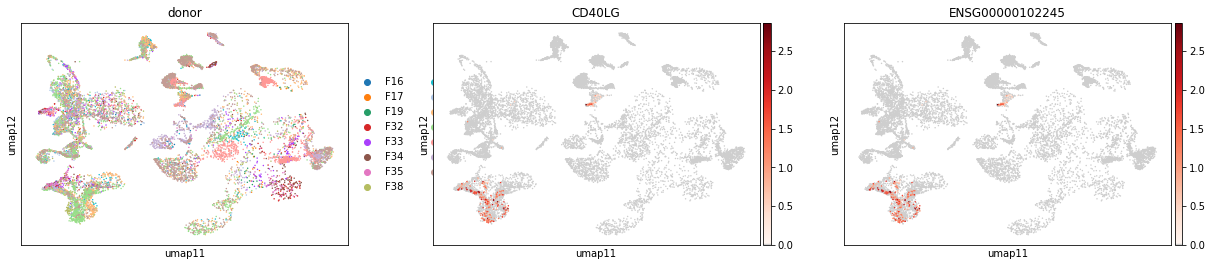

In [40]:
sc.pl.embedding(
    ad1S,
    basis="umap1",
    color=["donor", "CD40LG", "ENSG00000102245"],
    gene_symbols="gene_ids",
    cmap=expr_cmap,
)

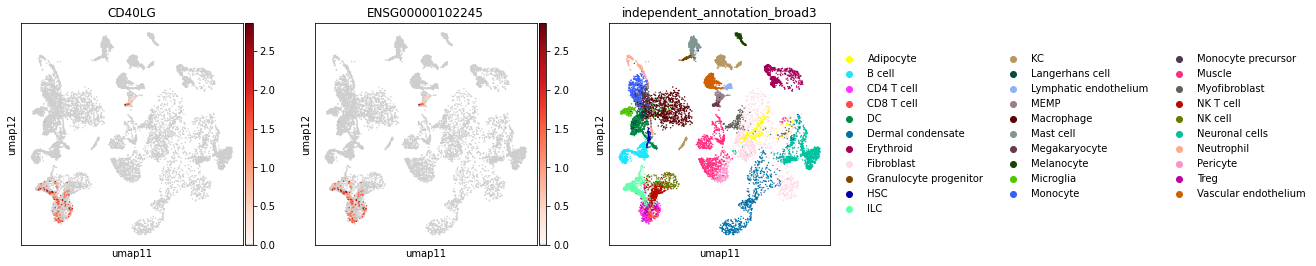

In [44]:
sk.set_figsize((4, 4))
sc.pl.embedding(
    ad1S,
    basis="umap1",
    color=[
        "CD40LG",
        "ENSG00000102245",
        "independent_annotation_broad3",
    ],
    gene_symbols="gene_ids",
    cmap=expr_cmap,
)